Validation RMSE: 0.144065


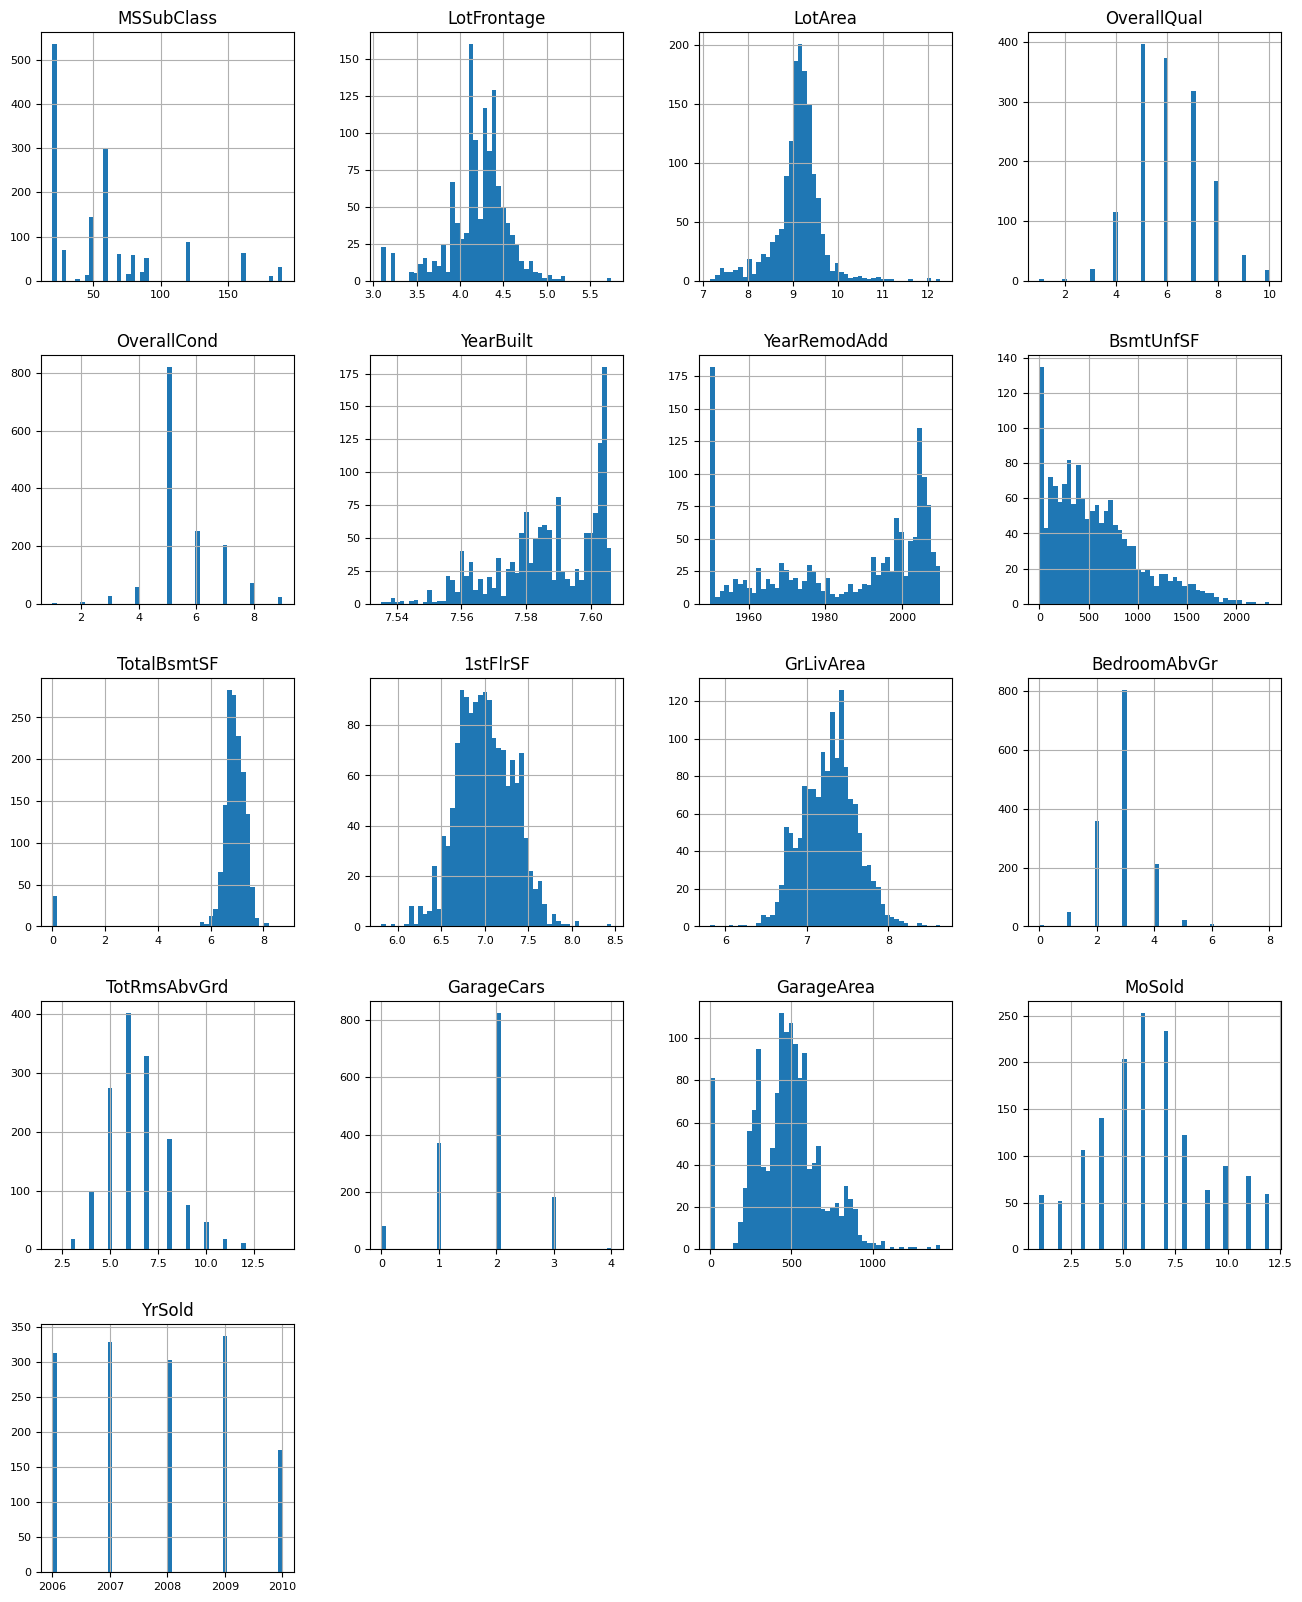

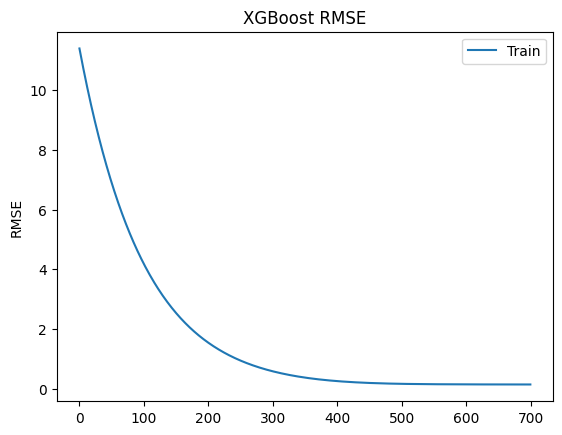

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the data
train_data = pd.read_csv('C:/Users/user/Downloads/train.csv')
test_data = pd.read_csv('C:/users/user/Downloads/test.csv')

# Apply log transformation to skew fields
fields_to_log = ['LotArea', 'LotFrontage', 'YearBuilt', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']
for field in fields_to_log:
    train_data[field] = np.log1p(train_data[field])
    test_data[field] = np.log1p(test_data[field])

# Select numerical columns only
numerical_cols = train_data.select_dtypes(include = ['float64', 'int64'])

# Remove specified columns
cols_to_remove = ['3SsnPorch', 'HalfBath', 'BsmtHalfBath','BsmtFinSF2', 'Id', 'PoolArea', 'SalePrice', 'GarageYrBlt', 
                  'LowQualFinSF', 'BsmtFullBath', '2ndFlrSF', 'LowQualFinSF','EnclosedPorch', 
                  'Fireplaces', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'KitchenAbvGr', 'FullBath', 'MasVnrArea','BsmtFinSF1', 'OpenPorchSF', 'WoodDeckSF']

numerical_cols = numerical_cols.drop(columns=cols_to_remove)
numerical_cols.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

# Prepare training data
X = numerical_cols
y = np.log1p(train_data['SalePrice'])

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model with regularization parameters
model = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01, max_depth = 5, n_estimators = 700, reg_alpha=0.2, reg_lambda=0.2)

# Train the model with early stopping
model.fit(X_train, y_train, 
          eval_set=[(X_val, y_val)], 
          verbose=False)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Compute RMSE on the validation set
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
print("Validation RMSE: %f" % (rmse))

# Plot RMSE over number of trees
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

# Prepare test data
X_test = test_data[X.columns]  # test data doesn't have 'SalePrice'

# Make predictions on the test set
y_test_pred = np.expm1(model.predict(X_test))  # Remember to transform predictions back to original scale

# Prepare submission dataframe
submission2 = pd.DataFrame({
    "Id": test_data["Id"],
    "SalePrice": y_test_pred
})

# Save to csv
submission2.to_csv('submission2.csv', index=False)
